In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_regression

from deepthink.optimizers import SGD, Adam
from deepthink.layers import Dense, Conv2D, MaxPooling, Flatten
from deepthink.model import Model
from deepthink.activations import ReLU, TanH, Softmax, ELU
from deepthink.utils import load_mnist_data
from deepthink.loss import MeanSquaredError, CategoricalCrossEntropy


# Set default matplotlib style sheet
plt.style.use('ggplot')

# Gradient checking

Gradient checking is a method used to verify the correctness of the backpropagation algorithm. This involves perturbing the model parameters by a small amount and computing the loss function before and after the perturbation. We can then compare the model's gradient estimations (numeric gradients) to the gradients estimated using the central difference formula (the analytic gradients). See [this link](https://lcn.people.uic.edu/classes/che205s17/docs/che205s17_reading_01e.pdf) for more information on numerical differentiation. We perform this perturbation on all the model parameters and then compare the analytic and numeric gradient estimations. If they are very small we can be confident that gradient computation is correct, if not this is a sign that there may be an issue with the implementation. A difference of less than 1e-7 is generally considered successful.

The central difference formula is defined as:
$$
 f'(x) \approx \frac{f(x+h)-f(x-h)}{2h}
$$

Gradient checking is only used for debugging purposes since it is computationally expensive. Once we can confirm the implementation is working correctly it is much quicker to train using the model's backpropagation algorithm. It is also worth noting that when performing gradient checking we need to use float64 instead of float32 data-type. This is because we are perturbing by a small amount (typically \~1e-5 or so) so precision becomes important.

[This link](https://cs231n.github.io/neural-networks-3/#gradcheck) from Stanford's CS231n course was very useful for this notebook. 

## Gradient checking regression model

We will start by gradient checking a simple neural network with one hidden layer on a regression task. The dataset is created using scikit-learn's 'make_regression'. This is just a simple toy dataset so it is ideal for gradient checking.

In [2]:
# Helper functions

def get_analytic_gradients(model, X_sample, y_sample,
                           epsilon=1e-5):
    """
    Return a model's analytic gradient approximations.

    Used to compute a model's gradients as part of
    gradient checking. Each weight and bias parameter
    is perturbed by a small value, epsilon, and the
    central difference formula is used to estimate
    the gradient. Gradients estimations are
    returned as an array.

    Parameters
    ----------
    model : Model
        Instantiated Model class to obtain the
        gradient approximations from.
    X_sample : numpy.array
        The X-data to use.
    y_sample : numpy.array
        The target labels for the sample data.
    epsilon : float,default=1e-5
        The constant used to perturb the parameters.

    Returns
    -------
    gradients : np.array
        The model's analytic gradient estimations. A
        1D array representing each parameter's estimated
        gradient.

    References
    ----------
    - https://cs231n.github.io/neural-networks-3/#gradcheck
    """
    # Get base loss
    probas = model.forward(X_sample)
    base_loss = model.cost(y_sample, probas)
    print('Base loss: ', base_loss)
    gradients = []
    init_params = model.get_params()
    print('Number of params: ', len(init_params))
    for p_idx in tqdm(range(len(init_params))):
        # Copy initial parameters and increase by epsilon
        theta_plus = init_params.copy()
        theta_plus[p_idx] += epsilon
        model.set_params(theta_plus)
        output1 = model.forward(X_sample)
        # Get loss using theta plus as weights
        loss1 = model.cost(y_sample, output1)

        # Copy initial parameters and decrease by epsilon
        theta_sub = init_params.copy()
        theta_sub[p_idx] -= epsilon
        model.set_params(theta_sub)
        output2 = model.forward(X_sample)
        loss2 = model.cost(y_sample, output2)

        # Use central difference equation to get gradient estimate
        grad = (loss1 - loss2) / (2 * epsilon)
        gradients.append(grad)
    # Reset model weights and biases to original values
    model.set_params(init_params)

    return np.array(gradients)


def gradient_check(model, X_batch, y_batch):
    """
    Used to perform gradient check on a model by
    perturbing model weights and comparing analytic
    and numeric gradient estimations.

    Parameters
    ----------
    model : Model
        Instantiated Model class to obtain the
        gradient approximations from.
    X_batch : numpy.array
        The X-data to use.
    y_batch : numpy.array
        The target labels for the sample data.

    Returns
    -------
    diff : float
        The relative difference between numeric
        and analytic gradients.
    num_grads : np.array
        The numeric gradients. Obtained by performing
        one forward pass and obtaining loss using the
        model's base weights & biases.
    ana_grads : np.array
        The analytic gradients. Computed by perturbing
        each model parameter and using the central
        difference equation to get gradient estimates.
    """
    # Get the analytic gradients
    ana_grads = get_analytic_gradients(model, X_batch, y_batch)
    # Get model loss & gradients
    out = model.forward(X_batch)
    loss = model.cost(y_batch, out)
    dZ = model.cost.grads()
    # Backpropagate
    model.backward(dZ)
    # Store numeric gradient estimations in 1D array
    num_grads = []
    for layer in model.layers:
        if hasattr(layer, 'weights'):
            num_grads.extend(layer.dweights.flatten())
            num_grads.extend(layer.dbiases.flatten())
    # Calculate relative difference between analytic & numeric gradients
    numerator = np.linalg.norm(num_grads - ana_grads)
    denominator = np.linalg.norm(ana_grads) + np.linalg.norm(num_grads)
    diff = numerator / denominator
    return diff, num_grads, ana_grads


def plot_grads(num_grads, ana_grads):
    """
    Plots numeric gradients, analytic gradients
    and the difference between them. Used for
    visualizing any errors or anomalies.
    """
    diffs_arr = (num_grads - ana_grads)

    fig, axes = plt.subplots(3, 1, figsize=(15, 15))
    axes[0].plot(num_grads)
    axes[0].set_title('Numeric Gradients')
    axes[0].set_ylabel('Gradient estimate')
    axes[1].plot(ana_grads)
    axes[1].set_title('Analytic Gradients')
    axes[1].set_ylabel('Gradient estimate')
    axes[2].plot(diffs_arr)
    axes[2].set_title('Difference between arrays')
    axes[2].set_ylabel('Relative difference')

    plt.xlabel('Model parameters')
    plt.show()

In [3]:
# Creating the dataset
X_data, y_data = make_regression(n_samples=5000,
                                 n_features=6,
                                 n_informative=6,
                                 n_targets=1,
                                 noise=0.5,
                                 random_state=42)
# Reshape target to column vector
y_data = y_data.reshape(-1, 1)
print(X_data.shape, y_data.shape)

(5000, 6) (5000, 1)


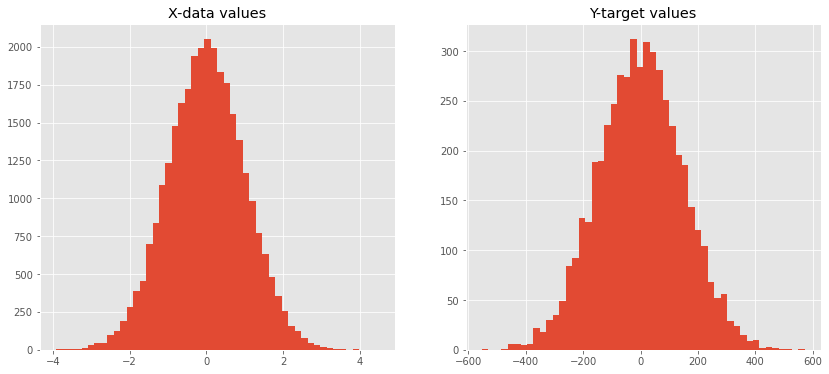

In [4]:
# Plot histograms to get idea of value distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(X_data.flatten(), bins=50)
axes[0].set_title('X-data values')
axes[1].hist(y_data.flatten(), bins=50)
axes[1].set_title('Y-target values')

plt.show()

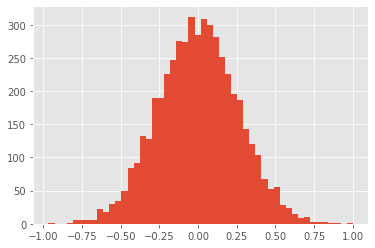

In [5]:
# Scale target values to be in range -1 to 1
# by dividing by absolute maximum value
abs_max = np.max(np.abs(y_data))
y_data = y_data / abs_max

plt.hist(y_data, bins=50)
plt.show()

In [6]:
# Hyperparameters
input_dims = X_data.shape[1]
learning_rate = 0.05
batch_size = 4
init_type = 'he_uniform'

In [7]:
# Building the model
opt = Adam(learning_rate)
model = Model(opt, cost=MeanSquaredError(),
              batch_size=batch_size, dtype=np.float64)
model.add_layer(Dense(16, n_inputs=input_dims,
                      weight_init=init_type))
model.add_layer(ELU())
model.add_layer(Dense(1, weight_init=init_type))
model.add_layer(ELU())

model.initialize()

In [8]:
# select random batch of data to use for gradient check
indices = np.random.randint(0, X_data.shape[0], batch_size)
X_batch = X_data[indices]
y_batch = y_data[indices]

In [9]:
diff, num_grads, ana_grads = gradient_check(model, X_batch, y_batch)

print('Difference: ', diff)

Base loss:  1.1770972548360306
Number of params:  129


100%|███████████████████████████████████████| 129/129 [00:00<00:00, 6745.86it/s]

Difference:  3.0013518848576806e-11


## Gradient checking simple NN on MNIST

The results above show that the model passes the gradient check since the relative difference is smaller than our threshold value of 10e-7.

We now move on to classification tasks where we use the MNIST dataset. This is a very common dataset in machine learning, more information can be found [here](http://yann.lecun.com/exdb/mnist/). Categorical cross-entropy is now used as the loss function instead of mean-squared error since we have multiple classes.

We start with a simple model with one hidden layer of 16 neurons then a model with two hidden layers. We can then move on to gradient checking convolutional networks.

In [10]:
# Load MNIST dataset
training_data, test_data = load_mnist_data(filepath='../Data/mnist784.p',
                                           flat_data=True)

X_train, y_train = training_data
X_test, y_test = test_data

print(f'Train data: {X_train.shape}, train labels: {y_train.shape}')
print(f'Test data: {X_train.shape}, test labels: {y_train.shape}')

Train data: (60000, 784), train labels: (60000, 10)
Test data: (60000, 784), test labels: (60000, 10)


In [11]:
# Building a NN model with one layer
opt = SGD(learning_rate)
model = Model(opt, cost=CategoricalCrossEntropy(),
              batch_size=batch_size,
              dtype=np.float64)
model.add_layer(Dense(16, n_inputs=784))
model.add_layer(ReLU())
model.add_layer(Dense(10))
model.add_layer(Softmax())

model.initialize()

In [12]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Dense Layer               (None, 16)                        12544
ReLU Activation           (None, 16)                            0
Dense Layer               (None, 10)                          160
Softmax Activation        (None, 10)                            0
Total params: 12,730


In [13]:
# Get the batch of data to use for gradient check
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

In [14]:
diff, num_grads, ana_grads = gradient_check(model, X_batch, y_batch)

print('Difference: ', diff)

Base loss:  2.5225774418750366
Number of params:  12730


100%|███████████████████████████████████| 12730/12730 [00:02<00:00, 5110.47it/s]

Difference:  6.210972371205267e-11


In [15]:
# Neural net with two hidden layers
opt = SGD(learning_rate)
model = Model(opt, cost=CategoricalCrossEntropy(),
              batch_size=batch_size, dtype=np.float64)
model.add_layer(Dense(16, n_inputs=784))
model.add_layer(ReLU())
model.add_layer(Dense(16))
model.add_layer(ReLU())
model.add_layer(Dense(10))
model.add_layer(Softmax())

model.initialize()

In [16]:
diff, num_grads, ana_grads = gradient_check(model, X_batch, y_batch)

print('Difference: ', diff)

Base loss:  2.869791560479123
Number of params:  13002


100%|███████████████████████████████████| 13002/13002 [00:02<00:00, 4622.56it/s]

Difference:  5.128018979584021e-11


## Gradient checking CNN model

Now that we have successfully tested a fully-connected neural network we need to check that a Convolutional Neural Network (CNN) will pass a gradient check. The backpropagation algorithm is more complex in a CNN due to the convolution step itself and also the other operations and layers.

### Differentiating the max-pooling layer

The max-pooling layer is a type of layer that is used to down-sample the spatial dimensions of the input data. This is typically done to reduce the computational complexity of the network, as well as to reduce the number of parameters and improve the generalization performance of the model.

The max-pooling layer propagates the gradient back to the indices where the value was equal to the max-value in that window. In our implementation this means that if multiple instances exist of the max-value then the gradient is back-propagated to all of them. It is unlikely that there would be multiple instances of the same maximum value in one local window, however this can cause issues for gradient checking. This propagates the correct error to multiple indices instead of just one.

In practice, this is unlikely to occur (values in activation layer are usually floats with lots of numbers after decimal point) and it does not really cause any errors, other than the error is propagated slightly more than we would envisage. But it can cause issues for gradient checking. I found that either adding some random noise or training slightly before gradient checking solves this issue, as can scaling input data to be from -1 to 1 (instead from 0-1).

### Differentiating ReLU

One problem that I encountered was with ReLU failing the gradient check. This was because ReLU is not differentiable. when the input equals zero, and there are a lot of zero values in the MNIST dataset. In order to get it to pass I added some noise to the input, another solution would be to train the model for a few batches before gradient checking. See [this link](https://cs231n.github.io/neural-networks-3/#gradcheck) for more information about this in the "Kinks in the objective" section.

In [17]:
# Hyperparameters
learning_rate = 0.05
batch_size = 4
kernel_size = 5
n_filters = 2
init_type = 'he_normal'

In [18]:
# Reshape data from flattened to 2D image dims
X_train = (X_train.reshape(-1, 1, 28, 28))
X_test = X_test.reshape(-1, 1, 28, 28)

In [19]:
opt = SGD(learning_rate)
model = Model(opt, cost=CategoricalCrossEntropy(),
              batch_size=batch_size, dtype=np.float64)

model.add_layer(Conv2D(kernel_size=kernel_size, n_filters=n_filters,
                       padding=2, stride=1,
                       weight_init=init_type,
                       input_shape=(batch_size, 1, 28, 28)))
model.add_layer(ReLU())
model.add_layer(Conv2D(kernel_size=kernel_size, n_filters=n_filters,
                       padding=0, stride=2,
                       weight_init=init_type))
model.add_layer(ReLU())
model.add_layer(MaxPooling())
model.add_layer(Flatten())
model.add_layer(Dense(10, weight_init=init_type))
model.add_layer(Softmax())

model.initialize()

In [20]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Conv2D                    (None, 2, 28, 28)                    50
ReLU Activation           (None, 2, 28, 28)                     0
Conv2D                    (None, 2, 12, 12)                   100
ReLU Activation           (None, 2, 12, 12)                     0
MaxPooling                (None, 2, 6, 6)                       0
Flatten                   (None, 72)                            0
Dense Layer               (None, 10)                          720
Softmax Activation        (None, 10)                            0
Total params: 884


In [21]:
# create random normal data array to add to data
noise = np.random.randn(batch_size, 1, 28, 28) * 0.25
# Get the batch of data to use for gradient check
X_batch = X_train[:batch_size] + noise
y_batch = y_train[:batch_size]

print(X_batch.shape, y_batch.shape)

(4, 1, 28, 28) (4, 10)


In [22]:
diff, num_grads, ana_grads = gradient_check(model, X_batch, y_batch)

print('Difference: ', diff)

Base loss:  3.1727395749012883
Number of params:  884


100%|████████████████████████████████████████| 884/884 [00:01<00:00, 837.19it/s]

Difference:  4.2238333841846636e-11


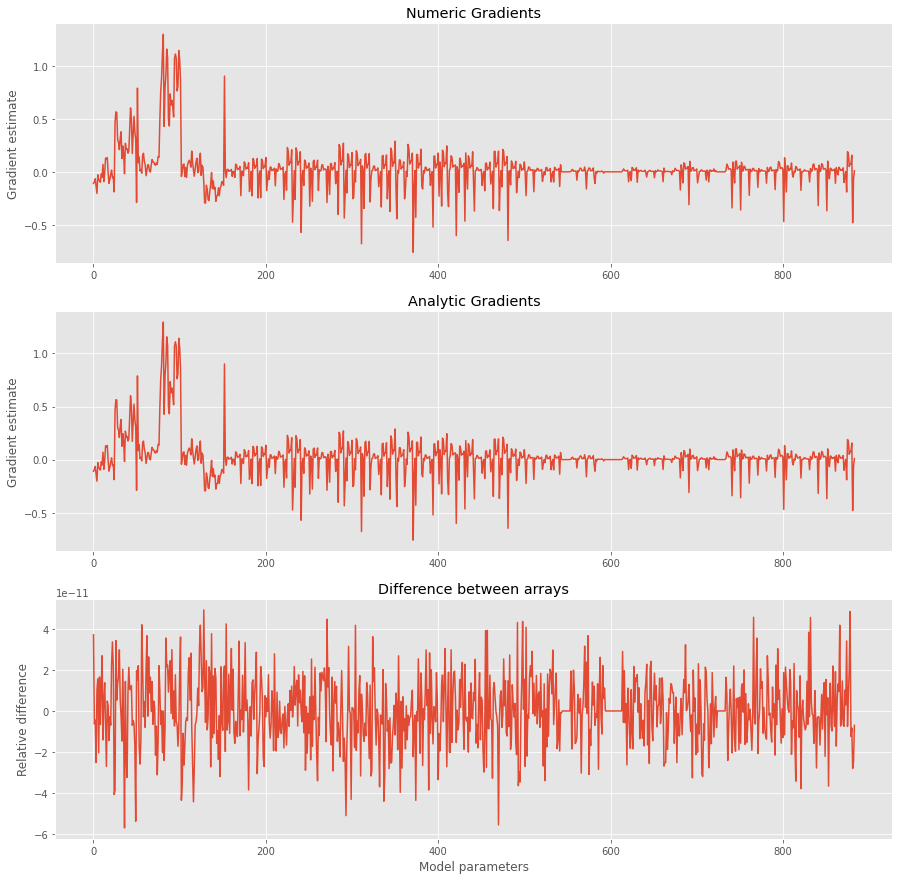

In [23]:
# Visualize the gradient estimations
plot_grads(num_grads, ana_grads)